## Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models, layers, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Load data

#### We use grayscale color mode since these are X-ray images. Binary class mode is used to distinguish between normal and pneumonia images.

In [2]:
train_data_dir = 'ZhangLabData/CellData/chest_xray/train'
test_data_dir = 'ZhangLabData/CellData/chest_xray/test'

#Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
       test_data_dir, 
       target_size=(64, 64), batch_size=132, color_mode='grayscale', class_mode='binary')

#Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
       train_data_dir, 
       target_size=(64, 64), batch_size=790, color_mode='grayscale', class_mode='binary')

#Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [3]:
print(train_labels[:10])

[0. 1. 1. 1. 1. 1. 1. 1. 0. 1.]


## PREPROCESSING
#### We will create a validation set from the training set in order to initially evaluate the model. If the model works well, we will fit it against the entire training set and validate against the testing set.

In [4]:
# Create validation set from training set

X = train_images
y = train_labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [5]:
train_images.shape

(790, 64, 64, 1)

#### Preview images (Normal)

In [6]:
print('X_train shape: ',np.shape(X_train))
print('y_train shape: ',np.shape(y_train))
print('X_val shape: ',np.shape(X_val))
print('y_val shape: ',np.shape(y_val))

X_train shape:  (632, 64, 64, 1)
y_train shape:  (632,)
X_val shape:  (158, 64, 64, 1)
y_val shape:  (158,)


In [7]:
test_images.shape

(132, 64, 64, 1)

#### Reshape  images

In [8]:
#train set
X_train_unrow = X_train.reshape(632, -1)
X_train_unrow.shape

(632, 4096)

In [9]:
#test set
X_val_unrow = X_val.reshape(158, -1)
X_val_unrow.shape

(158, 4096)

#### Labels for images

In [10]:
y_train[:10]

array([1., 1., 0., 1., 1., 0., 1., 1., 1., 0.], dtype=float32)

In [11]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

#### Scaling the data for analysis and modeling 

In [12]:
#scaling the data
X_train_img_final = X_train_unrow/255
X_val_img_final = X_val_unrow/255

type(X_val_img_final)

numpy.ndarray

In [13]:
print(X_train_img_final.shape)
print(X_val_img_final.shape)

(632, 4096)
(158, 4096)


## Model creation
#### We will use recall as our metric, as we're more concerned about false negatives than false positives.

#### Baseline Model with DummyClassifier

In [14]:
#dummy classifer/regressor for baseline
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_img_final, y_train)

DummyClassifier(strategy='most_frequent')

In [15]:
dummy.predict(X_val_img_final)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.], dtype=float32)

In [16]:
dummy.score(X_val_img_final, y_val)

0.7468354430379747

#### Initial Neural Network Model Creation using softmax activation function

In [17]:
np.random.seed(42)
model = models.Sequential()
model.add(layers.Dense(63, activation='softmax', input_shape=(4096,)))
model.add(layers.Dense(42, activation='softmax'))
model.add(layers.Dense(21, activation='softmax'))
model.add(layers.Dense(1, activation='sigmoid')) #output layer, binary classification

In [18]:
# import tensorflow as tf

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(), 'acc'])

results = model.fit(X_train_img_final,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val_img_final, y_val))

Epoch 1/50
20/20 [==============================] - 1s 67ms/step - loss: 0.6641 - recall: 1.0000 - acc: 0.7500 - val_loss: 0.6593 - val_recall: 1.0000 - val_acc: 0.7468
Epoch 2/50
20/20 [==============================] - 0s 5ms/step - loss: 0.6545 - recall: 1.0000 - acc: 0.7500 - val_loss: 0.6503 - val_recall: 1.0000 - val_acc: 0.7468
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6459 - recall: 1.0000 - acc: 0.7500 - val_loss: 0.6424 - val_recall: 1.0000 - val_acc: 0.7468
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 0.6382 - recall: 1.0000 - acc: 0.7500 - val_loss: 0.6351 - val_recall: 1.0000 - val_acc: 0.7468
Epoch 5/50
20/20 [==============================] - 0s 6ms/step - loss: 0.6311 - recall: 1.0000 - acc: 0.7500 - val_loss: 0.6285 - val_recall: 1.0000 - val_acc: 0.7468
Epoch 6/50
20/20 [==============================] - 0s 5ms/step - loss: 0.6247 - recall: 1.0000 - acc: 0.7500 - val_loss: 0.6226 - val_recall: 1.0000 - val_acc

20/20 [==============================] - 0s 8ms/step - loss: 0.5639 - recall: 1.0000 - acc: 0.7500 - val_loss: 0.5669 - val_recall: 1.0000 - val_acc: 0.7468
Epoch 50/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5637 - recall: 1.0000 - acc: 0.7500 - val_loss: 0.5668 - val_recall: 1.0000 - val_acc: 0.7468


In [19]:
results_train = model.evaluate(X_train_img_final, y_train)

20/20 [==============================] - 0s 4ms/step - loss: 0.5637 - recall: 1.0000 - acc: 0.7500


In [20]:
results_val = model.evaluate(X_val_img_final, y_val)

5/5 [==============================] - 0s 2ms/step - loss: 0.5668 - recall: 1.0000 - acc: 0.7468


In [21]:
#plot epochs vs loss for train and test set
def visualize_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    

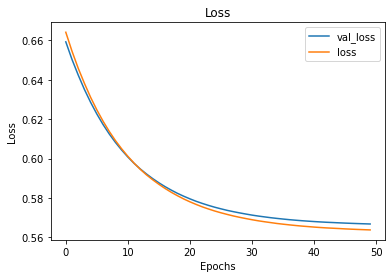

In [22]:
visualize_results(results)

#### Evaluate model with confusion matrix

In [23]:
label_pred = (model.predict(X_val_img_final) > 0.5).astype(int)

cf_matrix = confusion_matrix(y_val, label_pred)

<AxesSubplot:>

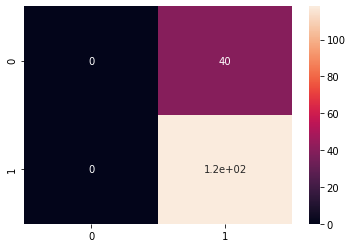

In [24]:
sns.heatmap(cf_matrix, annot=True)

#### Insight: according to the Loss plot, there is significant overfitting of the model due to the high variation of the validation curve. Any subsequent models must reduce the variance and overfitting of the baseline model.


#### Will adding EarlyStopping improve the model?

In [25]:
#create new model with similar parameters
np.random.seed(42)
model2 = models.Sequential()
model2.add(layers.Dense(63, activation='softmax', input_shape=(4096,)))
model2.add(layers.Dense(42, activation='softmax'))
model2.add(layers.Dense(21, activation='softmax'))
model2.add(layers.Dense(1, activation='sigmoid')) #output layer, binary classification

In [26]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), ModelCheckpoint(filepath='best_model.h5',
                                                                                 monitor='val_loss', save_best_only=True)]

In [27]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(), 'acc'])

results2 = model2.fit(X_train_img_final,
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val_img_final, y_val))

Epoch 1/50
20/20 [==============================] - 1s 64ms/step - loss: 0.6902 - recall_1: 0.7046 - acc: 0.6108 - val_loss: 0.6836 - val_recall_1: 1.0000 - val_acc: 0.7468
Epoch 2/50
20/20 [==============================] - 0s 7ms/step - loss: 0.6780 - recall_1: 1.0000 - acc: 0.7500 - val_loss: 0.6722 - val_recall_1: 1.0000 - val_acc: 0.7468
Epoch 3/50
20/20 [==============================] - 0s 13ms/step - loss: 0.6670 - recall_1: 1.0000 - acc: 0.7500 - val_loss: 0.6621 - val_recall_1: 1.0000 - val_acc: 0.7468
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 0.6571 - recall_1: 1.0000 - acc: 0.75 - 0s 9ms/step - loss: 0.6572 - recall_1: 1.0000 - acc: 0.7500 - val_loss: 0.6529 - val_recall_1: 1.0000 - val_acc: 0.7468
Epoch 5/50
20/20 [==============================] - 0s 12ms/step - loss: 0.6483 - recall_1: 1.0000 - acc: 0.7500 - val_loss: 0.6446 - val_recall_1: 1.0000 - val_acc: 0.7468
Epoch 6/50
20/20 [==============================] - 0s 10ms/step - loss: 0.6403 -

Epoch 48/50
20/20 [==============================] - 0s 5ms/step - loss: 0.5643 - recall_1: 1.0000 - acc: 0.7500 - val_loss: 0.5672 - val_recall_1: 1.0000 - val_acc: 0.7468
Epoch 49/50
20/20 [==============================] - 0s 8ms/step - loss: 0.5641 - recall_1: 1.0000 - acc: 0.7500 - val_loss: 0.5671 - val_recall_1: 1.0000 - val_acc: 0.7468
Epoch 50/50
20/20 [==============================] - 0s 5ms/step - loss: 0.5640 - recall_1: 1.0000 - acc: 0.7500 - val_loss: 0.5670 - val_recall_1: 1.0000 - val_acc: 0.7468


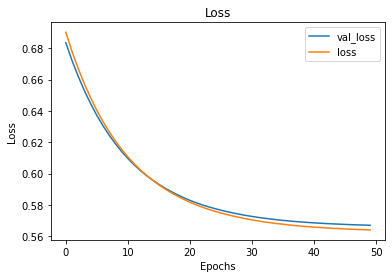

In [28]:
visualize_results(results2)

#### Variation in val_loss is still very high. Additionally, overfitting issue still hasn't been resolved. Will build a CNN, then attempt to control overfitting.

In [29]:
#CNN model
np.random.seed(42)
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3,3), activation='softmax',
                        input_shape=(64, 64, 1)))

model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='softmax'))
model3.add(layers.Dense(42, activation='softmax'))
model3.add(layers.Dense(21, activation='softmax'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [30]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                7872576   
_________________________________________________________________
dense_9 (Dense)              (None, 42)                2730      
_________________________________________________________________
dense_10 (Dense)             (None, 21)                903       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 22        
Total params: 7,876,551
Trainable params: 7,876,551
Non-trainable params: 0
____________________________________________

In [31]:
model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(), 'acc'])

results3 = model3.fit(X_train,
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 2s 98ms/step - loss: 0.6749 - recall_2: 1.0000 - acc: 0.7500 - val_loss: 0.6693 - val_recall_2: 1.0000 - val_acc: 0.7468
Epoch 2/50
20/20 [==============================] - 2s 87ms/step - loss: 0.6641 - recall_2: 1.0000 - acc: 0.7500 - val_loss: 0.6594 - val_recall_2: 1.0000 - val_acc: 0.7468
Epoch 3/50
20/20 [==============================] - 2s 84ms/step - loss: 0.6546 - recall_2: 1.0000 - acc: 0.7500 - val_loss: 0.6504 - val_recall_2: 1.0000 - val_acc: 0.7468
Epoch 4/50
20/20 [==============================] - 2s 85ms/step - loss: 0.6459 - recall_2: 1.0000 - acc: 0.7500 - val_loss: 0.6423 - val_recall_2: 1.0000 - val_acc: 0.7468
Epoch 5/50
20/20 [==============================] - 2s 84ms/step - loss: 0.6381 - recall_2: 1.0000 - acc: 0.7500 - val_loss: 0.6351 - val_recall_2: 1.0000 - val_acc: 0.7468
Epoch 6/50
20/20 [==============================] - 2s 83ms/step - loss: 0.6311 - recall_2: 1.0000 - acc: 0.7500 - val_loss: 0.6286 - v

20/20 [==============================] - 2s 83ms/step - loss: 0.5641 - recall_2: 1.0000 - acc: 0.7500 - val_loss: 0.5671 - val_recall_2: 1.0000 - val_acc: 0.7468
Epoch 49/50
20/20 [==============================] - 2s 81ms/step - loss: 0.5640 - recall_2: 1.0000 - acc: 0.7500 - val_loss: 0.5670 - val_recall_2: 1.0000 - val_acc: 0.7468
Epoch 50/50
20/20 [==============================] - 2s 94ms/step - loss: 0.5638 - recall_2: 1.0000 - acc: 0.7500 - val_loss: 0.5669 - val_recall_2: 1.0000 - val_acc: 0.7468


In [32]:
results_train4 = model3.evaluate(X_train, y_train)

20/20 [==============================] - 0s 18ms/step - loss: 0.5638 - recall_2: 1.0000 - acc: 0.7500


In [33]:
results_val4 = model3.evaluate(X_val, y_val)

5/5 [==============================] - 0s 15ms/step - loss: 0.5669 - recall_2: 1.0000 - acc: 0.7468


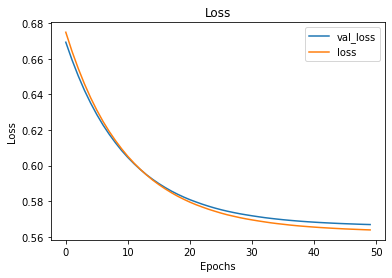

In [34]:
visualize_results(results3)

#### The accuracy of the model still hasn't changed. From here, we will attempt L1 and L2 regularization

#### L2 regularization with model3 structure

In [35]:
np.random.seed(42)


lambda_coeff = 0.005

model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3,3), activation='softmax',
                        input_shape=(64, 64, 1)))

model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='softmax', kernel_regularizer=regularizers.l2(lambda_coeff)))
model4.add(layers.Dense(42, activation='softmax', kernel_regularizer=regularizers.l2(lambda_coeff)))
model4.add(layers.Dense(21, activation='softmax', kernel_regularizer=regularizers.l2(lambda_coeff)))
model4.add(layers.Dense(1, activation='sigmoid'))

In [36]:
model4.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(), 'acc'])

results4 = model4.fit(X_train, 
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 2s 120ms/step - loss: 1.7068 - recall_3: 1.0000 - acc: 0.7500 - val_loss: 1.6986 - val_recall_3: 1.0000 - val_acc: 0.7468
Epoch 2/50
20/20 [==============================] - 2s 106ms/step - loss: 1.6913 - recall_3: 1.0000 - acc: 0.7500 - val_loss: 1.6839 - val_recall_3: 1.0000 - val_acc: 0.7468
Epoch 3/50
20/20 [==============================] - 2s 107ms/step - loss: 1.6770 - recall_3: 1.0000 - acc: 0.7500 - val_loss: 1.6703 - val_recall_3: 1.0000 - val_acc: 0.7468
Epoch 4/50
20/20 [==============================] - 2s 104ms/step - loss: 1.6637 - recall_3: 1.0000 - acc: 0.7500 - val_loss: 1.6578 - val_recall_3: 1.0000 - val_acc: 0.7468
Epoch 5/50
20/20 [==============================] - 2s 105ms/step - loss: 1.6515 - recall_3: 1.0000 - acc: 0.7500 - val_loss: 1.6461 - val_recall_3: 1.0000 - val_acc: 0.7468
Epoch 6/50
20/20 [==============================] - 2s 105ms/step - loss: 1.6400 - recall_3: 1.0000 - acc: 0.7500 - val_loss: 1.63

Epoch 48/50
20/20 [==============================] - 2s 104ms/step - loss: 1.4135 - recall_3: 1.0000 - acc: 0.7500 - val_loss: 1.4146 - val_recall_3: 1.0000 - val_acc: 0.7468
Epoch 49/50
20/20 [==============================] - 2s 104ms/step - loss: 1.4099 - recall_3: 1.0000 - acc: 0.7500 - val_loss: 1.4111 - val_recall_3: 1.0000 - val_acc: 0.7468
Epoch 50/50
20/20 [==============================] - 2s 104ms/step - loss: 1.4064 - recall_3: 1.0000 - acc: 0.7500 - val_loss: 1.4076 - val_recall_3: 1.0000 - val_acc: 0.7468


In [37]:
results_train4 = model4.evaluate(X_train, y_train)

20/20 [==============================] - 0s 23ms/step - loss: 1.4046 - recall_3: 1.0000 - acc: 0.7500


In [38]:
results_val4 = model4.evaluate(X_val, y_val)

5/5 [==============================] - 0s 21ms/step - loss: 1.4076 - recall_3: 1.0000 - acc: 0.7468


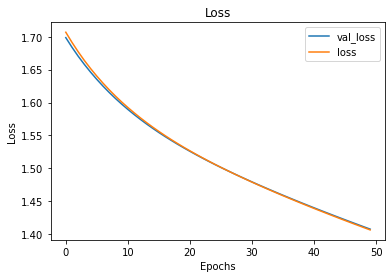

In [39]:
visualize_results(results4)

#### Insight: despite the curves converging in an ideal manner, the accuracy and recall values are still incorrect for our purposes. We will attempt to use padding in the convolutional layer, and reduce the complexity of the model to improve these values.

In [40]:
#reducing layers and nodes within layers
np.random.seed(42)

lambda_coeff = 0.005

model5 = models.Sequential()
model5.add(layers.Conv2D(32, (3,3), activation='softmax',
                        input_shape=(64, 64, 1), padding='same'))

model5.add(layers.Flatten())
model5.add(layers.Dense(16, activation='softmax', kernel_regularizer=regularizers.l2(lambda_coeff)))
model5.add(layers.Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(lambda_coeff)))

model5.add(layers.Dense(1, activation='sigmoid'))

In [41]:
model5.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(), 'acc'])

results5 = model5.fit(X_train, 
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 2s 89ms/step - loss: 0.8884 - recall_4: 1.0000 - acc: 0.7500 - val_loss: 0.8786 - val_recall_4: 1.0000 - val_acc: 0.7468
Epoch 2/50
20/20 [==============================] - 2s 76ms/step - loss: 0.8683 - recall_4: 1.0000 - acc: 0.7500 - val_loss: 0.8561 - val_recall_4: 1.0000 - val_acc: 0.7468
Epoch 3/50
20/20 [==============================] - 2s 76ms/step - loss: 0.8484 - recall_4: 1.0000 - acc: 0.7500 - val_loss: 0.8427 - val_recall_4: 1.0000 - val_acc: 0.7468
Epoch 4/50
20/20 [==============================] - 2s 76ms/step - loss: 0.8377 - recall_4: 1.0000 - acc: 0.7500 - val_loss: 0.8342 - val_recall_4: 1.0000 - val_acc: 0.7468
Epoch 5/50
20/20 [==============================] - 2s 76ms/step - loss: 0.8297 - recall_4: 1.0000 - acc: 0.7500 - val_loss: 0.8269 - val_recall_4: 1.0000 - val_acc: 0.7468
Epoch 6/50
20/20 [==============================] - 2s 76ms/step - loss: 0.8226 - recall_4: 1.0000 - acc: 0.7500 - val_loss: 0.8203 - v

20/20 [==============================] - 2s 75ms/step - loss: 0.7394 - recall_4: 1.0000 - acc: 0.7500 - val_loss: 0.7420 - val_recall_4: 1.0000 - val_acc: 0.7468
Epoch 49/50
20/20 [==============================] - 2s 76ms/step - loss: 0.7386 - recall_4: 1.0000 - acc: 0.7500 - val_loss: 0.7413 - val_recall_4: 1.0000 - val_acc: 0.7468
Epoch 50/50
20/20 [==============================] - 2s 75ms/step - loss: 0.7378 - recall_4: 1.0000 - acc: 0.7500 - val_loss: 0.7405 - val_recall_4: 1.0000 - val_acc: 0.7468


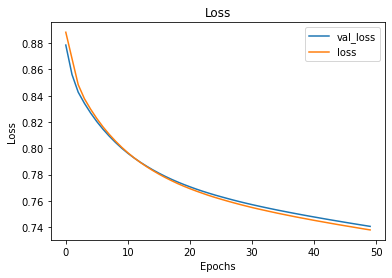

In [42]:
visualize_results(results5)

In [43]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                2097168   
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 9         
Total params: 2,097,633
Trainable params: 2,097,633
Non-trainable params: 0
_________________________________________________________________


#### The model fails to improve. Will dropout regularization improve the metrics?

In [44]:
np.random.seed(42)

model6 = models.Sequential()
model6.add(layers.Conv2D(32, (3,3), activation='softmax',
                        input_shape=(64, 64, 1)))

model6.add(layers.Flatten())
model6.add(layers.Dense(16, activation='softmax', kernel_regularizer=regularizers.l2(lambda_coeff)))
model6.add(layers.Dropout(0.3))
model6.add(layers.Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(lambda_coeff)))
model6.add(layers.Dropout(0.3))
model6.add(layers.Dense(1, activation='sigmoid'))

In [45]:
model6.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(), 'acc'])

results6 = model6.fit(X_train, 
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 2s 84ms/step - loss: 0.9501 - recall_5: 0.0527 - acc: 0.2816 - val_loss: 0.9383 - val_recall_5: 0.0000e+00 - val_acc: 0.2532
Epoch 2/50
20/20 [==============================] - 1s 71ms/step - loss: 0.9317 - recall_5: 0.2089 - acc: 0.3386 - val_loss: 0.9157 - val_recall_5: 0.0000e+00 - val_acc: 0.2532
Epoch 3/50
20/20 [==============================] - 1s 72ms/step - loss: 0.9097 - recall_5: 0.4177 - acc: 0.4446 - val_loss: 0.8963 - val_recall_5: 1.0000 - val_acc: 0.7468
Epoch 4/50
20/20 [==============================] - 1s 71ms/step - loss: 0.8852 - recall_5: 0.6772 - acc: 0.6171 - val_loss: 0.8806 - val_recall_5: 1.0000 - val_acc: 0.7468
Epoch 5/50
20/20 [==============================] - 1s 71ms/step - loss: 0.8764 - recall_5: 0.7932 - acc: 0.6519 - val_loss: 0.8674 - val_recall_5: 1.0000 - val_acc: 0.7468
Epoch 6/50
20/20 [==============================] - 1s 72ms/step - loss: 0.8662 - recall_5: 0.8629 - acc: 0.6820 - val_loss: 0.

20/20 [==============================] - 1s 71ms/step - loss: 0.7434 - recall_5: 1.0000 - acc: 0.7500 - val_loss: 0.7391 - val_recall_5: 1.0000 - val_acc: 0.7468
Epoch 49/50
20/20 [==============================] - 1s 72ms/step - loss: 0.7356 - recall_5: 1.0000 - acc: 0.7500 - val_loss: 0.7381 - val_recall_5: 1.0000 - val_acc: 0.7468
Epoch 50/50
20/20 [==============================] - 1s 72ms/step - loss: 0.7367 - recall_5: 1.0000 - acc: 0.7500 - val_loss: 0.7407 - val_recall_5: 1.0000 - val_acc: 0.7468


In [46]:
results_train6 = model6.evaluate(X_train, y_train)

20/20 [==============================] - 0s 17ms/step - loss: 0.7377 - recall_5: 1.0000 - acc: 0.7500


In [47]:
results_val6 = model6.evaluate(X_val, y_val)

5/5 [==============================] - 0s 13ms/step - loss: 0.7407 - recall_5: 1.0000 - acc: 0.7468


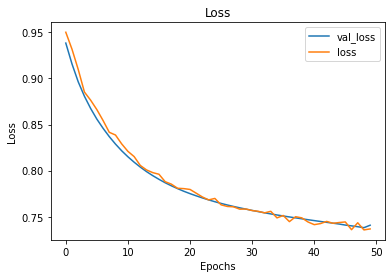

In [48]:
visualize_results(results6)

#### Dropout seems to increase variance in the training set compared to previous models. Will attempt using dropout with an increase in layer complexity, while using padding.

In [49]:
#introducing padding
np.random.seed(42)
model7 = models.Sequential()
model7.add(layers.Conv2D(32, (3,3), activation='softmax',
                        input_shape=(64, 64, 1), padding='same'))

model7.add(layers.Flatten())
model7.add(layers.Dense(42, activation='softmax'))
model7.add(layers.Dropout(0.3))
model7.add(layers.Dense(21, activation='softmax'))
model7.add(layers.Dropout(0.3))
model7.add(layers.Dense(1, activation='sigmoid'))

In [50]:
model7.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(), 'acc'])

results7 = model7.fit(X_train, 
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 2s 92ms/step - loss: 0.7125 - recall_6: 0.0295 - acc: 0.2627 - val_loss: 0.7041 - val_recall_6: 0.0000e+00 - val_acc: 0.2532
Epoch 2/50
20/20 [==============================] - 2s 82ms/step - loss: 0.6983 - recall_6: 0.2954 - acc: 0.3892 - val_loss: 0.6905 - val_recall_6: 1.0000 - val_acc: 0.7468
Epoch 3/50
20/20 [==============================] - 2s 83ms/step - loss: 0.6833 - recall_6: 0.8165 - acc: 0.6630 - val_loss: 0.6784 - val_recall_6: 1.0000 - val_acc: 0.7468
Epoch 4/50
20/20 [==============================] - 2s 84ms/step - loss: 0.6728 - recall_6: 0.9937 - acc: 0.7468 - val_loss: 0.6675 - val_recall_6: 1.0000 - val_acc: 0.7468
Epoch 5/50
20/20 [==============================] - 2s 83ms/step - loss: 0.6630 - recall_6: 1.0000 - acc: 0.7500 - val_loss: 0.6577 - val_recall_6: 1.0000 - val_acc: 0.7468
Epoch 6/50
20/20 [==============================] - 2s 82ms/step - loss: 0.6542 - recall_6: 1.0000 - acc: 0.7500 - val_loss: 0.6488

20/20 [==============================] - 2s 79ms/step - loss: 0.5655 - recall_6: 1.0000 - acc: 0.7500 - val_loss: 0.5672 - val_recall_6: 1.0000 - val_acc: 0.7468
Epoch 49/50
20/20 [==============================] - 2s 83ms/step - loss: 0.5631 - recall_6: 1.0000 - acc: 0.7500 - val_loss: 0.5670 - val_recall_6: 1.0000 - val_acc: 0.7468
Epoch 50/50
20/20 [==============================] - 2s 81ms/step - loss: 0.5654 - recall_6: 1.0000 - acc: 0.7500 - val_loss: 0.5669 - val_recall_6: 1.0000 - val_acc: 0.7468


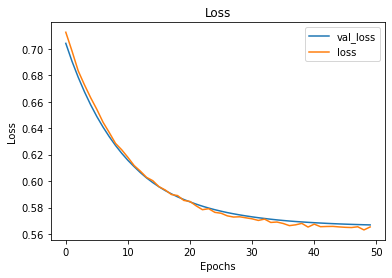

In [51]:
visualize_results(results7)

## Summary: 
#### After attempting regularization and dropout, model 3 consistently outperforms subsequent models due to have the lowest variance and loss for both train and validation sets. Despite this, the accuracy of these models are still very low and are no better than the dummy model. Taken together, it doesn't seem like softmax is a good activation function for predictions with this model. 